# Coffee Bean Classification with Deep Learning

### 1. Problem Statement

According to the Atlas of American Coffee, coffee consumption in the US surpasses that of any other beverage, including water, by 63%. As highlighted in Laura's 2019 report, the quality of coffee beans is paramount in determining the overall taste and consumer satisfaction. This project initially focuses on developing a Convolutional Neural Network (CNN) based deep learning model to classify coffee beans into categories based on their appearance: dark, green, light, and medium. This classification serves as a foundational step towards automating the quality assessment process. The goal is to evolve this model to not only categorize beans but also to detect key quality indicators, thereby providing a comprehensive tool for coffee shops and producers to monitor and enhance the overall quality of their beans.

Malseed, L. (2021, October 19). Ensuring the best coffee from harvest to cup with coffee quality control. Lavazza Business Solutions. 
https://insights.lavazzabusinesssolutions.com.au/ensuring-the-best-coffee-from-harvest-to-cup-with-coffee-quality-control

National Coffee Association. (2023, September 19). Celebrate National Coffee Day with latest data on America’s favorite beverage. 
https://www.ncausa.org/Newsroom/Celebrate-National-Coffee-Day-with-latest-data-on-Americas-favorite-beverage
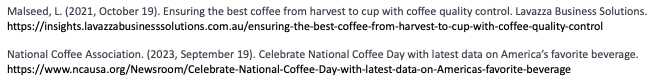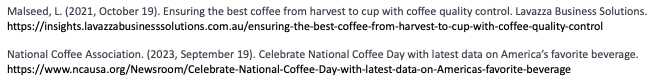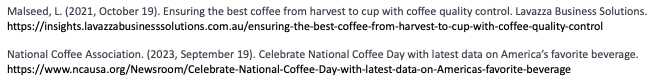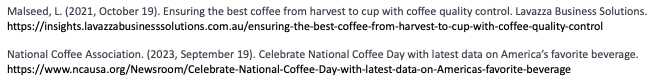

### 2. Hypothesis

In this project, I will develop CNN to classify coffee beans color types. The selected optimal model will achieve a high accuracy rate in classifying coffee beans into categories: dark, green, light, and medium.

### 3. Exploratory Data Analysis

In [1]:
#import all related libraries and packages

import os
import cv2
from random import choice
import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, load_model
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, GlobalAvgPool2D
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.optimizers.legacy import Adam, SGD,RMSprop 
from keras.applications.resnet_v2 import ResNet50V2, preprocess_input

In [2]:
# 3a. Import coffee bean file 
# This dataset already separate into train and test folder.
df = pd.read_csv('Coffee Bean.csv')
df.shape

(1600, 4)

In [3]:
# 3b. basic EDA
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1600 entries, 0 to 1599
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   class index  1600 non-null   int64 
 1   filepaths    1600 non-null   object
 2   labels       1600 non-null   object
 3   data set     1600 non-null   object
dtypes: int64(1), object(3)
memory usage: 50.1+ KB


In [4]:
# 3b. basic EDA
df.sample(5)

,class index,filepaths,labels,data set
988,3,train/Medium/medium (179).png,Medium,train
1320,1,test/Green/green (27).png,Green,test
1266,0,test/Dark/dark (69).png,Dark,test
1476,2,test/Light/light (78).png,Light,test
72,0,train/Dark/dark (164).png,Dark,train


In [5]:
# 3b. check if only 3 index in index column
unique_class_indices = df['class index'].unique()
print("Unique Class Indices:", unique_class_indices)

Unique Class Indices: [0 1 2 3]


In [6]:
# 3b. check how if 4 classes in labels
unique_labels = df['labels'].unique()
print("Unique Labels:", unique_labels)

Unique Labels: ['Dark' 'Green' 'Light' 'Medium']


In [7]:
# 3b. check if 2 datasets
unique_datasets = df['data set'].unique()
print("Unique Class Indices:", unique_datasets)

Unique Class Indices: ['train' 'test']


In [8]:
# 3b. check how many images in train and test folders
def explore_data(folder):
    for subfolder in os.listdir(folder):
        path = os.path.join(folder, subfolder)
        if os.path.isdir(path):
            num_images = len(os.listdir(path))
            print(f"There are {num_images} images in the '{subfolder}'.")

# Exploring train and test folders
train_df = 'train'
test_df = 'test'

explore_data(train_df)
explore_data(test_df)

There are 300 images in the 'Green'.
There are 300 images in the 'Medium'.
There are 300 images in the 'Light'.
There are 300 images in the 'Dark'.
There are 100 images in the 'Green'.
There are 100 images in the 'Medium'.
There are 100 images in the 'Light'.
There are 100 images in the 'Dark'.


**By checking train and test dataset, there is no imbalance situation exist.**

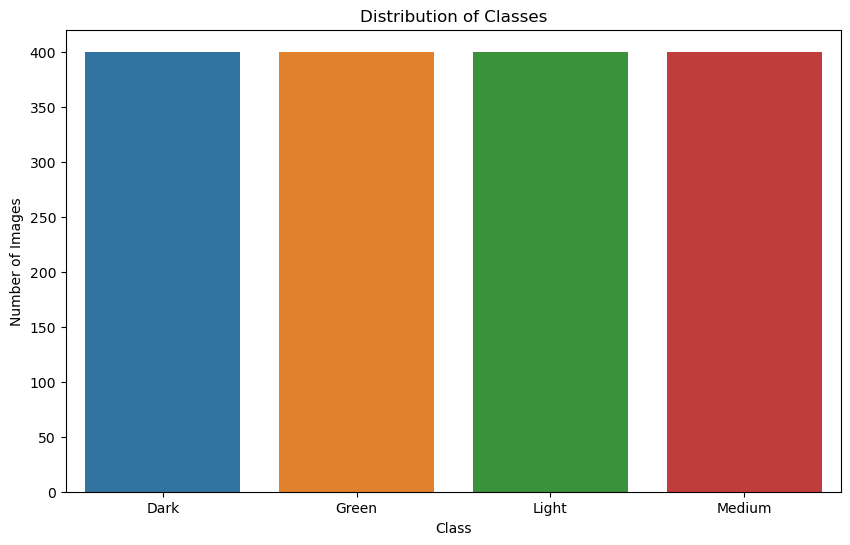

In [9]:
# 3b. present in visual
class_counts = df['labels'].value_counts()

plt.figure(figsize=(10, 6))
sns.barplot(x=class_counts.index, y=class_counts.values)
plt.title('Distribution of Classes')
plt.xlabel('Class')
plt.ylabel('Number of Images')
plt.show()


**This bar chart present all 4 classese are equally distributed which mean no bias.**

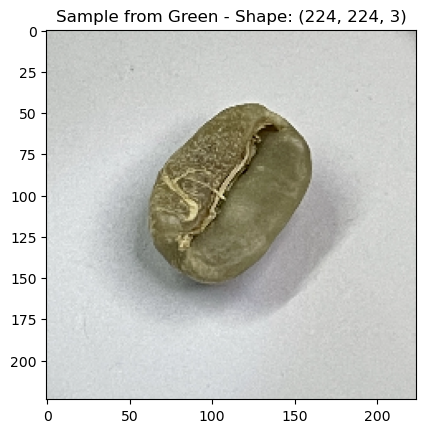

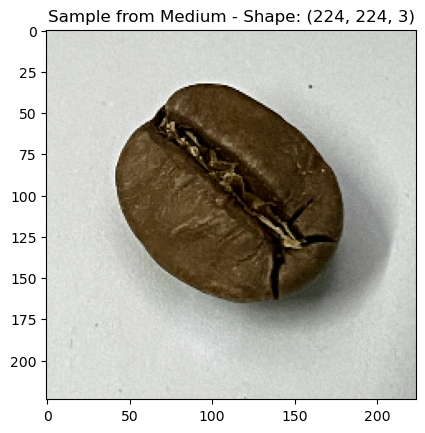

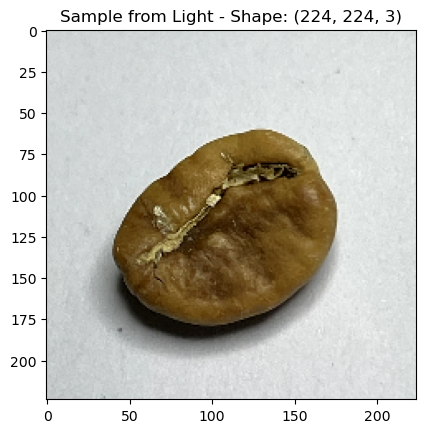

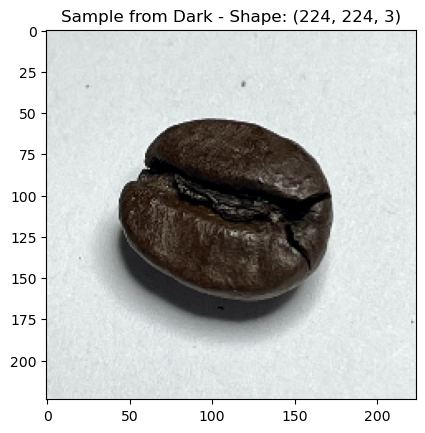

In [10]:
def display_sample_images(folder):
    for subfolder in os.listdir(folder):
        path = os.path.join(folder, subfolder)
        if os.path.isdir(path):
            sample_image = choice(os.listdir(path))
            img_path = os.path.join(path, sample_image)
            img = cv2.imread(img_path)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            plt.imshow(img)
            plt.title(f'Sample from {subfolder} - Shape: {img.shape}')
            plt.show()
            
display_sample_images(train_df)            

# 4. Feature Engineering & Transformations

In [11]:
# 4a. rescale,rotate,zoom and shear image to perform feature engineering and transformations
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

test_datagen = ImageDataGenerator(rescale=1./255)

### 5. Model Building

In [12]:
# 5a. create train and test set
train_data = train_datagen.flow_from_directory(
    train_df,
    target_size=(224, 224),  
    batch_size=32,
    class_mode='categorical'  
)


test_data = test_datagen.flow_from_directory(
    test_df,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

Found 1200 images belonging to 4 classes.
Found 400 images belonging to 4 classes.


In [13]:
# 5b. create a initial model by using CNN

# Model Building
model0 = Sequential()
model0.add(Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)))
model0.add(MaxPooling2D((2, 2)))
model0.add(Flatten())
model0.add(Dense(100, activation='relu'))
model0.add(Dropout(0.2))
model0.add(Dense(4, activation='softmax'))  

# Define the optimizer with a custom learning rate
optimizer = Adam(learning_rate=0.0001)

# Compile Model
model0.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Early Stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=10)

# Train Model
history = model0.fit(train_data, validation_data=test_data, epochs=10, callbacks=[early_stopping])

Epoch 1/10
38/38 [==============================] - 11s 268ms/step - loss: 6.8942 - accuracy: 0.4500 - val_loss: 0.5712 - val_accuracy: 0.7800
Epoch 2/10
38/38 [==============================] - 10s 268ms/step - loss: 0.4064 - accuracy: 0.8600 - val_loss: 0.4659 - val_accuracy: 0.8050
Epoch 3/10
38/38 [==============================] - 10s 267ms/step - loss: 0.2793 - accuracy: 0.9058 - val_loss: 0.2690 - val_accuracy: 0.9150
Epoch 4/10
38/38 [==============================] - 11s 275ms/step - loss: 0.1840 - accuracy: 0.9367 - val_loss: 0.1318 - val_accuracy: 0.9525
Epoch 5/10
38/38 [==============================] - 11s 275ms/step - loss: 0.1813 - accuracy: 0.9342 - val_loss: 0.1521 - val_accuracy: 0.9500
Epoch 6/10
38/38 [==============================] - 11s 285ms/step - loss: 0.1267 - accuracy: 0.9617 - val_loss: 0.2471 - val_accuracy: 0.9150
Epoch 7/10
38/38 [==============================] - 11s 274ms/step - loss: 0.1390 - accuracy: 0.9550 - val_loss: 0.0811 - val_accuracy: 0.9700

In [14]:
model0.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 111, 111, 32)      0         
 D)                                                              
                                                                 
 flatten (Flatten)           (None, 394272)            0         
                                                                 
 dense (Dense)               (None, 100)               39427300  
                                                                 
 dropout (Dropout)           (None, 100)               0         
                                                                 
 dense_1 (Dense)             (None, 4)                 404       
                                                        

In [15]:
model0.evaluate(test_data)

13/13 [==============================] - 1s 59ms/step - loss: 0.0758 - accuracy: 0.9700


[0.07580766826868057, 0.9700000286102295]

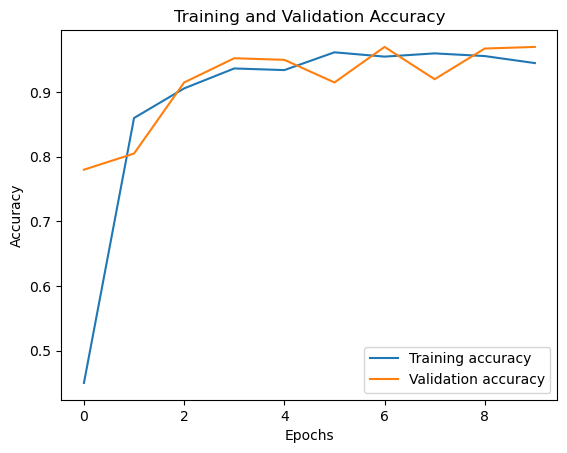

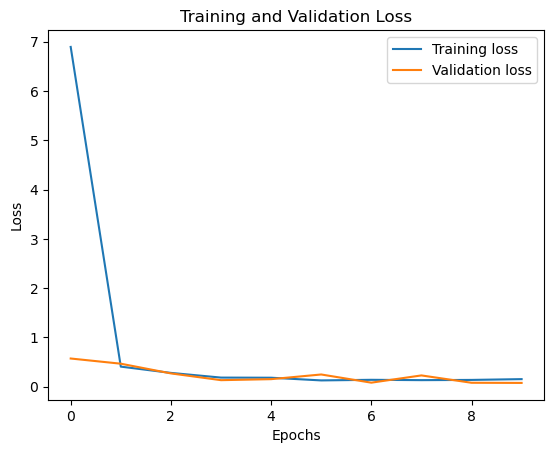

In [16]:
# 5c. check overfitting or underfitting

# Plot training & validation accuracy
plt.plot(history.history['accuracy'], label='Training accuracy')
plt.plot(history.history['val_accuracy'], label='Validation accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot training & validation loss
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


**From above plots, the initial model performs well in both training and validation set which indicate no over or underfitting**

### 6. Proposed Solution (Model Selection)

In [17]:
# 6a. by changing Dense level, Dense level 300, to improve model accuracy

# Model Building
model1 = Sequential()
model1.add(Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)))
model1.add(MaxPooling2D((2, 2)))
model1.add(Flatten())
model1.add(Dense(300, activation='relu'))
model1.add(Dropout(0.2))
model1.add(Dense(4, activation='softmax'))  

# Define the optimizer with a custom learning rate
optimizer = Adam(learning_rate=0.001)

# Compile Model
model1.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Early Stopping
early_stopping1 = EarlyStopping(monitor='val_loss', patience=10)

# Train Model
history1 = model1.fit(train_data, validation_data=test_data, epochs=10, callbacks=[early_stopping1])

Epoch 1/10
38/38 [==============================] - 14s 350ms/step - loss: 19.5908 - accuracy: 0.4208 - val_loss: 0.4424 - val_accuracy: 0.8950
Epoch 2/10
38/38 [==============================] - 13s 347ms/step - loss: 0.3217 - accuracy: 0.8975 - val_loss: 0.3272 - val_accuracy: 0.8700
Epoch 3/10
38/38 [==============================] - 14s 351ms/step - loss: 0.1944 - accuracy: 0.9292 - val_loss: 0.0940 - val_accuracy: 0.9700
Epoch 4/10
38/38 [==============================] - 14s 367ms/step - loss: 0.1607 - accuracy: 0.9475 - val_loss: 0.1856 - val_accuracy: 0.9350
Epoch 5/10
38/38 [==============================] - 15s 378ms/step - loss: 0.1424 - accuracy: 0.9533 - val_loss: 0.1144 - val_accuracy: 0.9550
Epoch 6/10
38/38 [==============================] - 15s 390ms/step - loss: 0.1496 - accuracy: 0.9517 - val_loss: 0.0951 - val_accuracy: 0.9675
Epoch 7/10
38/38 [==============================] - 16s 419ms/step - loss: 0.1447 - accuracy: 0.9500 - val_loss: 0.0885 - val_accuracy: 0.972

In [18]:
model1.evaluate(test_data)

13/13 [==============================] - 1s 104ms/step - loss: 0.0974 - accuracy: 0.9650


[0.09744814038276672, 0.9649999737739563]

In [19]:
# 6a. by changing Dense level, Dense level 500, to improve model accuracy

# Model Building
model2 = Sequential()
model2.add(Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)))
model2.add(MaxPooling2D((2, 2)))
model2.add(Flatten())
model2.add(Dense(500, activation='relu'))
model2.add(Dropout(0.2))
model2.add(Dense(4, activation='softmax'))  

optimizer = Adam(learning_rate=0.001)

# Compile Model
model2.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Early Stopping
early_stopping2 = EarlyStopping(monitor='val_loss', patience=10)

# Train Model
history2 = model2.fit(train_data, validation_data=test_data, epochs=10, callbacks=[early_stopping2])

Epoch 1/10
38/38 [==============================] - 27s 686ms/step - loss: 37.6153 - accuracy: 0.3625 - val_loss: 0.4969 - val_accuracy: 0.7525
Epoch 2/10
38/38 [==============================] - 25s 656ms/step - loss: 0.4572 - accuracy: 0.8350 - val_loss: 0.1960 - val_accuracy: 0.9450
Epoch 3/10
38/38 [==============================] - 24s 633ms/step - loss: 0.2179 - accuracy: 0.9317 - val_loss: 0.2485 - val_accuracy: 0.9050
Epoch 4/10
38/38 [==============================] - 24s 618ms/step - loss: 0.1978 - accuracy: 0.9275 - val_loss: 0.2712 - val_accuracy: 0.8850
Epoch 5/10
38/38 [==============================] - 24s 639ms/step - loss: 0.1821 - accuracy: 0.9383 - val_loss: 0.1389 - val_accuracy: 0.9500
Epoch 6/10
38/38 [==============================] - 25s 669ms/step - loss: 0.1528 - accuracy: 0.9533 - val_loss: 0.1956 - val_accuracy: 0.9350
Epoch 7/10
38/38 [==============================] - 26s 681ms/step - loss: 0.1250 - accuracy: 0.9550 - val_loss: 0.1458 - val_accuracy: 0.950

In [20]:
model2.evaluate(test_data)

13/13 [==============================] - 2s 170ms/step - loss: 0.1244 - accuracy: 0.9575


[0.12437877058982849, 0.9574999809265137]

In [21]:
# 6a. by changing Epoch level, Epoch level 20, to improve model accuracy

# Model Building
model3 = Sequential()
model3.add(Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)))
model3.add(MaxPooling2D((2, 2)))
model3.add(Flatten())
model3.add(Dense(100, activation='relu'))
model3.add(Dropout(0.2))
model3.add(Dense(4, activation='softmax'))  

optimizer = Adam(learning_rate=0.001)

# Compile Model
model3.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Early Stopping
early_stopping3 = EarlyStopping(monitor='val_loss', patience=10)

# Train Model
history3 = model3.fit(train_data, validation_data=test_data, epochs=20, callbacks=[early_stopping3])

Epoch 1/20
38/38 [==============================] - 15s 401ms/step - loss: 10.8341 - accuracy: 0.3175 - val_loss: 1.1452 - val_accuracy: 0.4775
Epoch 2/20
38/38 [==============================] - 15s 398ms/step - loss: 1.1151 - accuracy: 0.5183 - val_loss: 0.8775 - val_accuracy: 0.5950
Epoch 3/20
38/38 [==============================] - 14s 363ms/step - loss: 0.9256 - accuracy: 0.6192 - val_loss: 0.6971 - val_accuracy: 0.7025
Epoch 4/20
38/38 [==============================] - 14s 359ms/step - loss: 0.8120 - accuracy: 0.6817 - val_loss: 0.5573 - val_accuracy: 0.8200
Epoch 5/20
38/38 [==============================] - 14s 352ms/step - loss: 0.7362 - accuracy: 0.7192 - val_loss: 0.4604 - val_accuracy: 0.9000
Epoch 6/20
38/38 [==============================] - 14s 361ms/step - loss: 0.7110 - accuracy: 0.7300 - val_loss: 0.3757 - val_accuracy: 0.9175
Epoch 7/20
38/38 [==============================] - 14s 354ms/step - loss: 0.6300 - accuracy: 0.7442 - val_loss: 0.5294 - val_accuracy: 0.757

In [22]:
model3.evaluate(test_data)

13/13 [==============================] - 1s 82ms/step - loss: 0.2205 - accuracy: 0.9450


[0.22051683068275452, 0.9449999928474426]

In [23]:
# 6a. by changing Epoch level, Epoch level 20, to improve model accuracy

model4 = Sequential()
model4.add(Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)))
model4.add(MaxPooling2D((2, 2)))
model4.add(Flatten())
model4.add(Dense(300, activation='relu'))
model4.add(Dropout(0.2))
model4.add(Dense(4, activation='softmax'))  

optimizer = Adam(learning_rate=0.001)

# Compile Model
model4.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Early Stopping
early_stopping4 = EarlyStopping(monitor='val_loss', patience=10)

# Train Model
history4 = model4.fit(train_data, validation_data=test_data, epochs=20, callbacks=[early_stopping4])

Epoch 1/20
38/38 [==============================] - 19s 485ms/step - loss: 19.6240 - accuracy: 0.3642 - val_loss: 0.9451 - val_accuracy: 0.5225
Epoch 2/20
38/38 [==============================] - 19s 485ms/step - loss: 0.7128 - accuracy: 0.7483 - val_loss: 0.4344 - val_accuracy: 0.8850
Epoch 3/20
38/38 [==============================] - 19s 495ms/step - loss: 0.3947 - accuracy: 0.8700 - val_loss: 0.1905 - val_accuracy: 0.9525
Epoch 4/20
38/38 [==============================] - 19s 488ms/step - loss: 0.2997 - accuracy: 0.8983 - val_loss: 0.1577 - val_accuracy: 0.9475
Epoch 5/20
38/38 [==============================] - 19s 483ms/step - loss: 0.2313 - accuracy: 0.9217 - val_loss: 0.2134 - val_accuracy: 0.9225
Epoch 6/20
38/38 [==============================] - 19s 496ms/step - loss: 0.2156 - accuracy: 0.9325 - val_loss: 0.1282 - val_accuracy: 0.9575
Epoch 7/20
38/38 [==============================] - 19s 502ms/step - loss: 0.2188 - accuracy: 0.9300 - val_loss: 0.2192 - val_accuracy: 0.925

In [24]:
model4.evaluate(test_data)

13/13 [==============================] - 2s 113ms/step - loss: 0.1080 - accuracy: 0.9625


[0.10797753930091858, 0.9624999761581421]

In [25]:
# 6a. by changing Epoch level, Epoch level 20, to improve model accuracy

model5 = Sequential()
model5.add(Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)))
model5.add(MaxPooling2D((2, 2)))
model5.add(Flatten())
model5.add(Dense(500, activation='relu'))
model5.add(Dropout(0.2))
model5.add(Dense(4, activation='softmax'))  

optimizer = Adam(learning_rate=0.001)

# Compile Model
model5.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Early Stopping
early_stopping5 = EarlyStopping(monitor='val_loss', patience=10)

# Train Model
history5 = model5.fit(train_data, validation_data=test_data, epochs=20, callbacks=[early_stopping5])

Epoch 1/20
38/38 [==============================] - 28s 703ms/step - loss: 25.2431 - accuracy: 0.4008 - val_loss: 0.6701 - val_accuracy: 0.7000
Epoch 2/20
38/38 [==============================] - 28s 737ms/step - loss: 0.4661 - accuracy: 0.8317 - val_loss: 0.2814 - val_accuracy: 0.8975
Epoch 3/20
38/38 [==============================] - 27s 702ms/step - loss: 0.2430 - accuracy: 0.9142 - val_loss: 0.3189 - val_accuracy: 0.8750
Epoch 4/20
38/38 [==============================] - 27s 713ms/step - loss: 0.1982 - accuracy: 0.9308 - val_loss: 0.2541 - val_accuracy: 0.9025
Epoch 5/20
38/38 [==============================] - 27s 712ms/step - loss: 0.1556 - accuracy: 0.9517 - val_loss: 0.1333 - val_accuracy: 0.9450
Epoch 6/20
38/38 [==============================] - 27s 706ms/step - loss: 0.1535 - accuracy: 0.9508 - val_loss: 0.1939 - val_accuracy: 0.9400
Epoch 7/20
38/38 [==============================] - 27s 706ms/step - loss: 0.1346 - accuracy: 0.9533 - val_loss: 0.1072 - val_accuracy: 0.960

In [32]:
model5.evaluate(test_data)

13/13 [==============================] - 2s 113ms/step - loss: 0.0806 - accuracy: 0.9700


[0.08055175095796585, 0.9700000286102295]

In [38]:
table = {
    "Model": ["model0", "model1", "model2", "model3", "model4", "model5"],
    "Final Training Accuracy": [0.9450, 0.9642, 0.9608, 0.9000, 0.9567, 0.9733],
    "Final Validation Accuracy": [0.9700, 0.9650, 0.9575, 0.9450, 0.9625, 0.9700],
    "Final Training Loss": [0.1527, 0.1027, 0.1155, 0.2997, 0.1135, 0.0787],
    "Final Validation Loss": [0.0758, 0.0974, 0.1244, 0.2205, 0.1080, 0.0806],
    "Epochs": [10, 10, 10, 20, 20, 20],
    "Dense Layer": [100, 300, 500, 100, 300, 500]
}

# Creating a DataFrame to display the summary table
summary_table = pd.DataFrame(table)

# Output the summary table
summary_table

,Model,Final Training Accuracy,Final Validation Accuracy,Final Training Loss,Final Validation Loss,Epochs,Dense Layer
0,model0,0.9450,0.9700,0.1527,0.0758,10,100
1,model1,0.9642,0.9650,0.1027,0.0974,10,300
2,model2,0.9608,0.9575,0.1155,0.1244,10,500
3,model3,0.9000,0.9450,0.2997,0.2205,20,100
4,model4,0.9567,0.9625,0.1135,0.1080,20,300
5,model5,0.9733,0.9700,0.0787,0.0806,20,500


**Using the same optimizer, Adam, and changing the number of dense layers and epochs to select the optimal model, we observed that while Model 5 appears to have the highest final training accuracy and validation accuracy, the improvements are only marginal. Taking all factors into consideration, Model 1 will be chosen as the optimal model for coffee bean classification.**

In [39]:
# 6a. by changing Optimizer - SGD to improve model accuracy

model6 = Sequential()
model6.add(Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)))
model6.add(MaxPooling2D((2, 2)))
model6.add(Flatten())
model6.add(Dense(100, activation='relu'))
model6.add(Dropout(0.2))
model6.add(Dense(4, activation='softmax'))  

# Compile Model with legacy SGD optimizer
model6.compile(optimizer=SGD(learning_rate=0.001, momentum=0.9), 
               loss='categorical_crossentropy', 
               metrics=['accuracy'])

# Early Stopping
early_stopping6 = EarlyStopping(monitor='val_loss', patience=10)

# Train Model
history6 = model6.fit(train_data, validation_data=test_data, epochs=10, callbacks=[early_stopping6])

Epoch 1/10
38/38 [==============================] - 10s 266ms/step - loss: 1.4568 - accuracy: 0.2558 - val_loss: 1.3857 - val_accuracy: 0.1625
Epoch 2/10
38/38 [==============================] - 10s 267ms/step - loss: 1.3878 - accuracy: 0.2408 - val_loss: 1.3863 - val_accuracy: 0.2500
Epoch 3/10
38/38 [==============================] - 10s 270ms/step - loss: 1.3864 - accuracy: 0.2500 - val_loss: 1.3863 - val_accuracy: 0.2500
Epoch 4/10
38/38 [==============================] - 11s 277ms/step - loss: 1.3865 - accuracy: 0.2500 - val_loss: 1.3863 - val_accuracy: 0.2500
Epoch 5/10
38/38 [==============================] - 11s 278ms/step - loss: 1.3863 - accuracy: 0.2500 - val_loss: 1.3863 - val_accuracy: 0.2500
Epoch 6/10
38/38 [==============================] - 10s 262ms/step - loss: 1.3864 - accuracy: 0.2500 - val_loss: 1.3863 - val_accuracy: 0.2500
Epoch 7/10
38/38 [==============================] - 10s 271ms/step - loss: 1.3864 - accuracy: 0.2350 - val_loss: 1.3863 - val_accuracy: 0.2500

In [40]:
model6.evaluate(test_data)

13/13 [==============================] - 1s 59ms/step - loss: 1.3856 - accuracy: 0.2500


[1.3855791091918945, 0.25]

In [41]:
# 6a. by changing Optimizer - RMSprop to improve model accuracy

model7 = Sequential()
model7.add(Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)))
model7.add(MaxPooling2D((2, 2)))
model7.add(Flatten())
model7.add(Dense(100, activation='relu'))
model7.add(Dropout(0.2))
model7.add(Dense(4, activation='softmax'))  

# Compile Model with legacy SGD optimizer
model7.compile(optimizer=RMSprop(learning_rate=0.001, momentum=0.9), 
               loss='categorical_crossentropy', 
               metrics=['accuracy'])

# Early Stopping
early_stopping7 = EarlyStopping(monitor='val_loss', patience=10)

# Train Model
history7 = model7.fit(train_data, validation_data=test_data, epochs=10, callbacks=[early_stopping7])

Epoch 1/10
38/38 [==============================] - 11s 275ms/step - loss: 12.1042 - accuracy: 0.2908 - val_loss: 1.1295 - val_accuracy: 0.2800
Epoch 2/10
38/38 [==============================] - 11s 282ms/step - loss: 1.0020 - accuracy: 0.5667 - val_loss: 0.7865 - val_accuracy: 0.6550
Epoch 3/10
38/38 [==============================] - 11s 276ms/step - loss: 0.7790 - accuracy: 0.6583 - val_loss: 0.8127 - val_accuracy: 0.6200
Epoch 4/10
38/38 [==============================] - 11s 275ms/step - loss: 0.6525 - accuracy: 0.7142 - val_loss: 0.7322 - val_accuracy: 0.6500
Epoch 5/10
38/38 [==============================] - 11s 276ms/step - loss: 0.6003 - accuracy: 0.7350 - val_loss: 0.3945 - val_accuracy: 0.8100
Epoch 6/10
38/38 [==============================] - 11s 275ms/step - loss: 0.4546 - accuracy: 0.8200 - val_loss: 0.2286 - val_accuracy: 0.9150
Epoch 7/10
38/38 [==============================] - 11s 275ms/step - loss: 0.2914 - accuracy: 0.8867 - val_loss: 0.2241 - val_accuracy: 0.915

In [42]:
model7.evaluate(test_data)

13/13 [==============================] - 1s 55ms/step - loss: 0.3591 - accuracy: 0.8625


[0.3591073751449585, 0.862500011920929]

In [52]:
#summary table for different optimized by using same dense layer and epoch.

models_summary = {
    "Model": ["model1", "model6", "model7"],
    "Optimizer": ["Adam", "SGD", "RMSprop"] ,
    "Final Training Accuracy": [0.9642,  0.2525, 0.9333],
    "Final Validation Accuracy": [0.9650, 0.2500, 0.8625],
    "Final Training Loss": [0.1027,1.3865, 0.2072],
    "Final Validation Loss": [0.0974, 1.3856, 0.3591],
    "Epochs": [10,10, 10] 
}


df_models_summary = pd.DataFrame(models_summary)
df_models_sorted = df_models_summary.sort_values(by="Final Validation Accuracy")
df_models_summary

,Model,Optimizer,Final Training Accuracy,Final Validation Accuracy,Final Training Loss,Final Validation Loss,Epochs
1,model6,SGD,0.2525,0.2500,1.3865,1.3856,10
2,model7,RMSprop,0.9333,0.8625,0.2072,0.3591,10
0,model1,Adam,0.9642,0.9650,0.1027,0.0974,10


**Among different optimizers, Adam outperforms the others, making Model 1 the optimal choice.**

In [55]:
model_optimal = model1
history_optimal = history1

In [57]:
test_loss, test_accuracy = model_optimal.evaluate(test_data)
print(f"Test Accuracy: {test_accuracy*100:.2f}%, Test Loss: {test_loss}")

13/13 [==============================] - 1s 69ms/step - loss: 0.0974 - accuracy: 0.9650
Test Accuracy: 96.50%, Test Loss: 0.09744813293218613


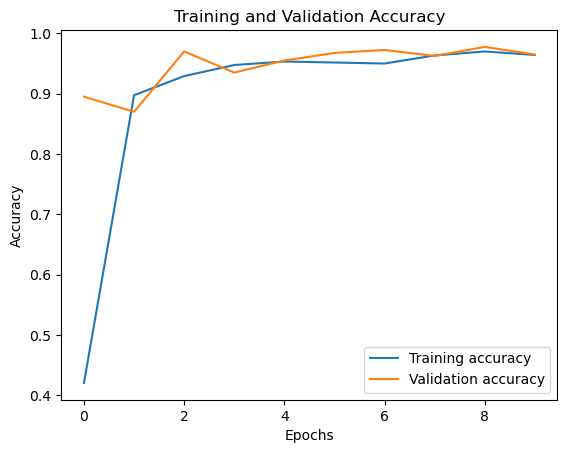

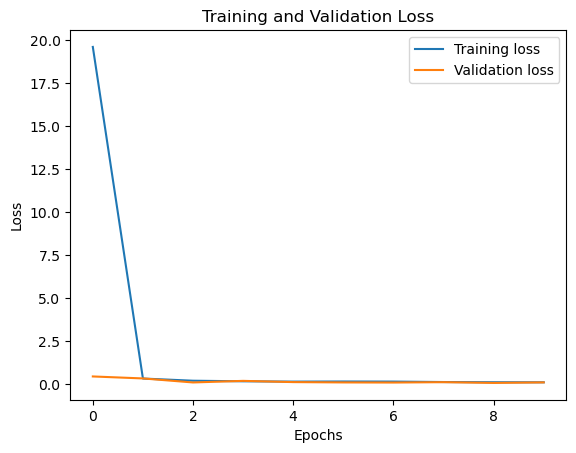

In [58]:
# Plot training & validation accuracy
plt.plot(history_optimal.history['accuracy'], label='Training accuracy')
plt.plot(history_optimal.history['val_accuracy'], label='Validation accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot training & validation loss
plt.plot(history_optimal.history['loss'], label='Training loss')
plt.plot(history_optimal.history['val_loss'], label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

### 7. Results (Accuracy) and Learnings from the methodology

In [59]:
#develop a function to load image from local path
def load_image(filename, img_shape = 224):
  img = tf.io.read_file(filename) 
  img = tf.image.decode_image(img)
  img = tf.image.resize(img, size = [img_shape, img_shape])
  img = img/255.
  return img

In [69]:
#develop a function to import, preprocess, predict and plot
def pred_image (model_optimal, filename, class_names):

  # import the target image and preprocess it
  img = load_image(filename)

  # make a prediction
  pred = model_optimal.predict(tf.expand_dims(img, axis=0))

  if len(pred[0]) > 1: # check for multi-class
    pred_class = class_names[pred.argmax()] 
  else:
    pred_class = class_names[int(tf.round(pred)[0][0])] 

  plt.imshow(img)
  plt.title(f"Prediction: {pred_class}")
  plt.axis(False);

In [70]:
class_names = list(train_data.class_indices.keys())

1/1 [==============================] - 0s 52ms/step


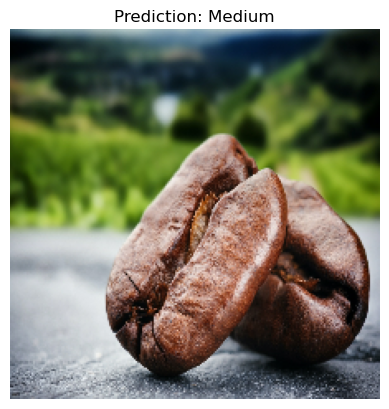

In [71]:
pred_image(model_optimal, "bean1.jpg", class_names)

**Using the optimal model to randomly plug in images to see if the model can accurately identify the color of coffee beans, we observed that the model accurately identifies the coffee bean colors.**

### 8. Future Work

1. Currently, this dataset contains only 1600 images. Increasing the dataset size can benefit the model's accuracy.

2. In model building, I chose Adam, SGD, and RMSprop. However, for SGD and RMSprop, I only selected 100 dense layers and 10 epochs. I should consider trying more settings for these two optimizers."

3. The final goal of this model is to automate the identification of defective coffee beans. Labeling these defective coffee beans is the next step.